In [24]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


## Dataset Inspection

Since the data is loaded using pandas, we can use methods such as `DataFrame.describe()` and `DataFrame.info()` to learn about the data. One thing to note here is that the original dataset does not come with headers and hence we also use the `names` attribute to create the headers based on the description of the dataset found in the `iris.names` file.

In [25]:
# Load dataset
data = pd.read_csv(
    "iris.data",
    names=["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
)

# Encode target labels
encoder = LabelEncoder()
data["class"] = encoder.fit_transform(data["class"])

# Features and target
X = data.iloc[:, 0:4].values
y = data["class"].values

print("Dataset loaded successfully")
print("Class mapping:", dict(enumerate(encoder.classes_)))


Dataset loaded successfully
Class mapping: {0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}


In [5]:
data.describe()

,sepal_width,sepal_length,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (120, 4)
Test set shape: (30, 4)


By counting the frequency of the classes, we now notice that we have a balanced dataset with 50 instances of each class. (This is also stated in `iris.names`)

In [27]:
MODEL_PATH = "iris_logistic_regression.pkl"

if os.path.exists(MODEL_PATH):
    model = joblib.load(MODEL_PATH)
    print("Loaded existing baseline model.")
else:
    model = LogisticRegression(
        max_iter=200,
        solver="lbfgs",
        multi_class="auto"
    )
    model.fit(X_train, y_train)
    joblib.dump(model, MODEL_PATH)
    print("Trained and saved new baseline model.")


Trained and saved new baseline model.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training Accuracy: 97.50%
Test Accuracy: 96.67%

Training Classification Report

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        40
Iris-versicolor       0.97      0.95      0.96        40
 Iris-virginica       0.95      0.97      0.96        40

       accuracy                           0.97       120
      macro avg       0.98      0.97      0.97       120
   weighted avg       0.98      0.97      0.97       120

Test Classification Report

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.90      0.95        10
 Iris-virginica       0.91      1.00      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



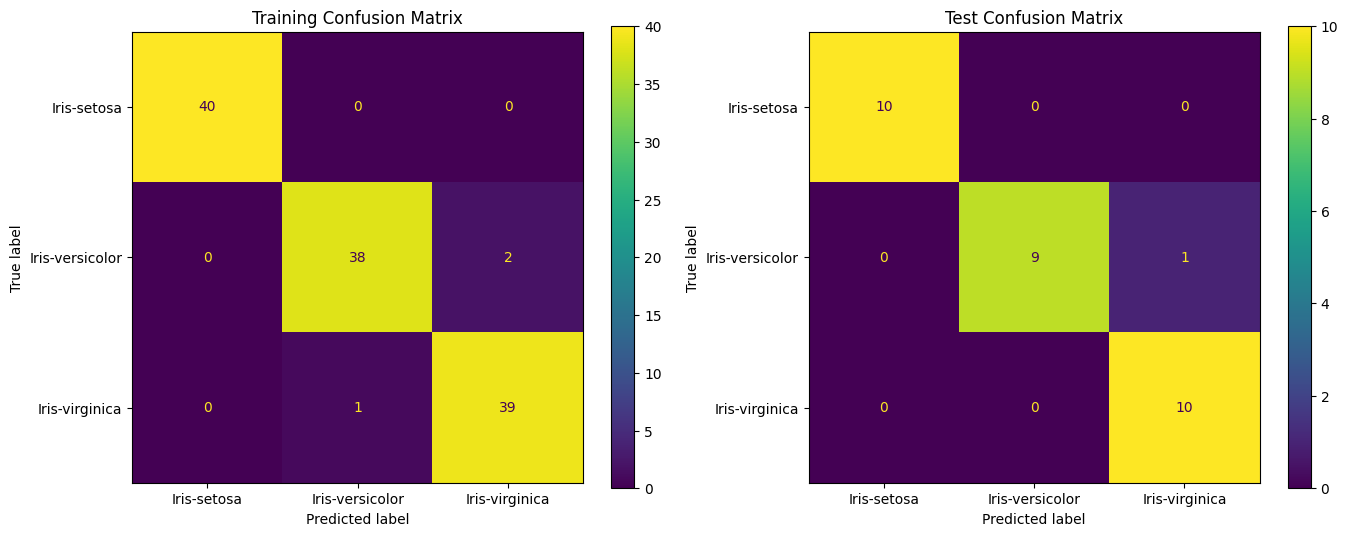

In [28]:
# Predictions
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Accuracy
train_accuracy = np.mean(y_train == train_preds)
test_accuracy = np.mean(y_test == test_preds)

print(f"Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%\n")

labels = encoder.classes_

print("Training Classification Report\n")
print(classification_report(y_train, train_preds, target_names=labels))

print("Test Classification Report\n")
print(classification_report(y_test, test_preds, target_names=labels))

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ConfusionMatrixDisplay.from_estimator(
    model, X_train, y_train, ax=axes[0], display_labels=labels
)
ConfusionMatrixDisplay.from_estimator(
    model, X_test, y_test, ax=axes[1], display_labels=labels
)

axes[0].set_title("Training Confusion Matrix")
axes[1].set_title("Test Confusion Matrix")

plt.show()


In [ ]:
pkl_filename = "iris_logistic_regression.pkl"

if pkl_filename not in os.listdir():
    with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)

loaded_model = pickle.load(open(pkl_filename, 'rb'))
print(type(loaded_model))

<class 'sklearn.linear_model._logistic.LogisticRegression'>


In [29]:
from sklearn.metrics import f1_score

baseline_f1 = f1_score(y_test, test_preds, average="macro")
print(f"Baseline Macro F1-score: {baseline_f1:.2f}")


Baseline Macro F1-score: 0.97


In [21]:
baseline_f1 = 1.00  # From Logistic Regression


In [22]:
# K-Nearest Neighbors (KNN) algorithms to compare with the logisitic regression


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

# Train candidate model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predictions
knn_preds = knn_model.predict(X_test)

# Metric (same metric as baseline!)
knn_f1 = f1_score(y_test, knn_preds, average="macro")

print(f"KNN Test Macro F1-score: {knn_f1:.2f}")


KNN Test Macro F1-score: 0.97


In [23]:
if knn_f1 >= baseline_f1:
    print("✅ Candidate model approved for deployment.")
    joblib.dump(knn_model, "approved_model.pkl")
else:
    print("❌ Candidate model rejected. Baseline performs better.")


❌ Candidate model rejected. Baseline performs better.


In [30]:
import json
from sklearn.metrics import f1_score

# Calculate baseline metric again (safe & explicit)
baseline_f1 = f1_score(y_test, test_preds, average="macro")

metrics = {
    "baseline_model": "Logistic Regression",
    "baseline_macro_f1": baseline_f1,
    "test_accuracy": test_accuracy,
    "candidate_model": "KNN",
    "candidate_status": "rejected",
    "evaluation_metric": "macro_f1"
}

with open("metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print("metrics.json created successfully")


metrics.json created successfully


In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
%%writefile README.md
# Iris Classification – ML Workflow Enhancement

## Project Overview
This project extends an existing open-source Iris classification repository by
modernizing the machine learning workflow and introducing a metric-driven model
promotion mechanism.

## What Was Implemented
- Reproducible train-test split with stratification
- Logistic Regression baseline model
- Model evaluation using accuracy, F1-score, and confusion matrices
- Candidate KNN model comparison
- Conditional deployment gate based on macro F1-score
- Metric persistence using artifacts (`metrics.json`)

## How to Run
1. Open the notebook in Google Colab
2. Upload the `iris.data` file
3. Run all cells from top to bottom

## Assumptions & Limitations
- The Iris dataset is small and clean
- Simple models were intentionally used to focus on MLOps concepts
- No external model registry was used

## Reflection on Using a Coding Assistant
Using a coding assistant helped speed up development and modernize deprecated
APIs. It was particularly useful for structuring the ML workflow and adding
deployment logic. Manual verification was required to ensure correctness and
best practices.


Writing README.md


In [34]:
ls

drive/     iris_logistic_regression.pkl  README.md
iris.data  metrics.json                  sample_data/


In [36]:
!git clone https://github.com/mrramanand/iris-classification.git


Cloning into 'iris-classification'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 22 (delta 7), reused 18 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 474.62 KiB | 7.91 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [37]:
%cd iris-classification


/content/iris-classification


In [38]:
ls


cf_matrix.py                    iris_logistic_regression.pkl  __pycache__/
iris.data                       iris.names                    README.md
iris_logistic_regression.ipynb  iris_neural_network.ipynb


In [39]:
!git status


On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean


In [41]:
!cp /content/iris_logistic_regression.pkl.ipynb .
!cp /content/metrics.json .
!cp /content/README.md .


cp: cannot stat '/content/iris_logistic_regression.pkl.ipynb': No such file or directory
